In [650]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, utils
from torchvision.transforms import ToTensor

In [766]:
# Define a transform to resize all images to a fixed size
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side to 256
    transforms.CenterCrop(224),  # Then center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3505, 0.3142, 0.3272], std=[0.1567, 0.1598, 0.1697]),
])

# Download training data from open datasets.
training_data = datasets.GTSRB(
    root="data",
    split = "train",
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.GTSRB(
    root="data",
    split="test",
    download=True,
    transform=transform,
)

#Used to plot images without normalization
image_test_data = datasets.GTSRB( 
    root = "data",
    split="test",
    download=True,
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
)


In [652]:
#Used to find the mean and STD for normalization:
loader = DataLoader(training_data, batch_size=1, shuffle=False, num_workers=4)

# Initialize variables to calculate the mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
n_samples = 0

# Loop through the dataset to calculate the mean and std
for images, _ in loader:
    # Flatten the image tensors into a long vector for each channel
    images = images.view(3, -1)
    
    # Update the total mean and std
    mean += images.mean(dim=1)
    std += images.std(dim=1)
    
    # Update the number of samples
    n_samples += 1

# Average the sum of means and stds by the number of samples
mean /= n_samples
std /= n_samples

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([ 2.1655e-04, -1.1535e-04,  2.4163e-05])
Standard Deviation: tensor([0.9997, 1.0001, 1.0003])


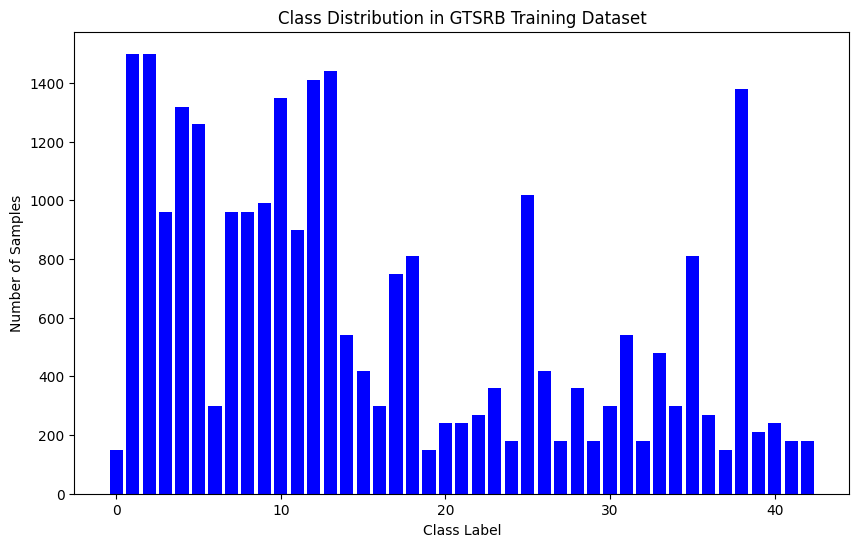

In [653]:
import matplotlib.pyplot as plt

# Step 1: Load the dataset without any transforms (just for counting purposes)
dataset = datasets.GTSRB(
    root="data",
    split="train",
    download=True,
    transform=None,
)

# Step 2: Initialize a dictionary to store the counts for each class
class_counts = {}

# Step 3: Loop through the dataset and count the instances of each class
for _, label in dataset:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Step 4: Sort the classes by label for better visualization
sorted_class_counts = dict(sorted(class_counts.items()))

# Step 5: Visualize the class distribution
plt.figure(figsize=(10, 6))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color='blue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in GTSRB Training Dataset')
plt.show()

In [654]:
labels = [label for _, label in dataset]
class_counts = np.bincount(labels)
class_weights = 1. / class_counts  #Invert the frequency to get class weights

#Assign a weight to each sample
sample_weights = class_weights[labels]

#Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [722]:
batch_size = 64

#Create Data Loaders:
train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler = sampler, shuffle = False, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle = False, num_workers=4)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64


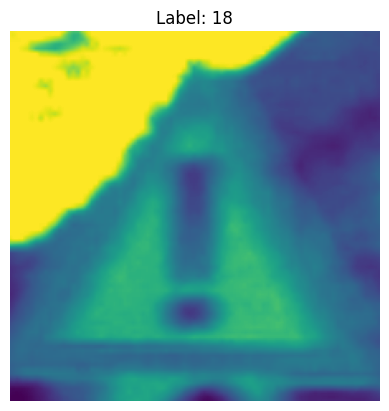

In [755]:
import matplotlib.pyplot as plt
def show_image(image, label):
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

show_image(X[42][0], y[42])

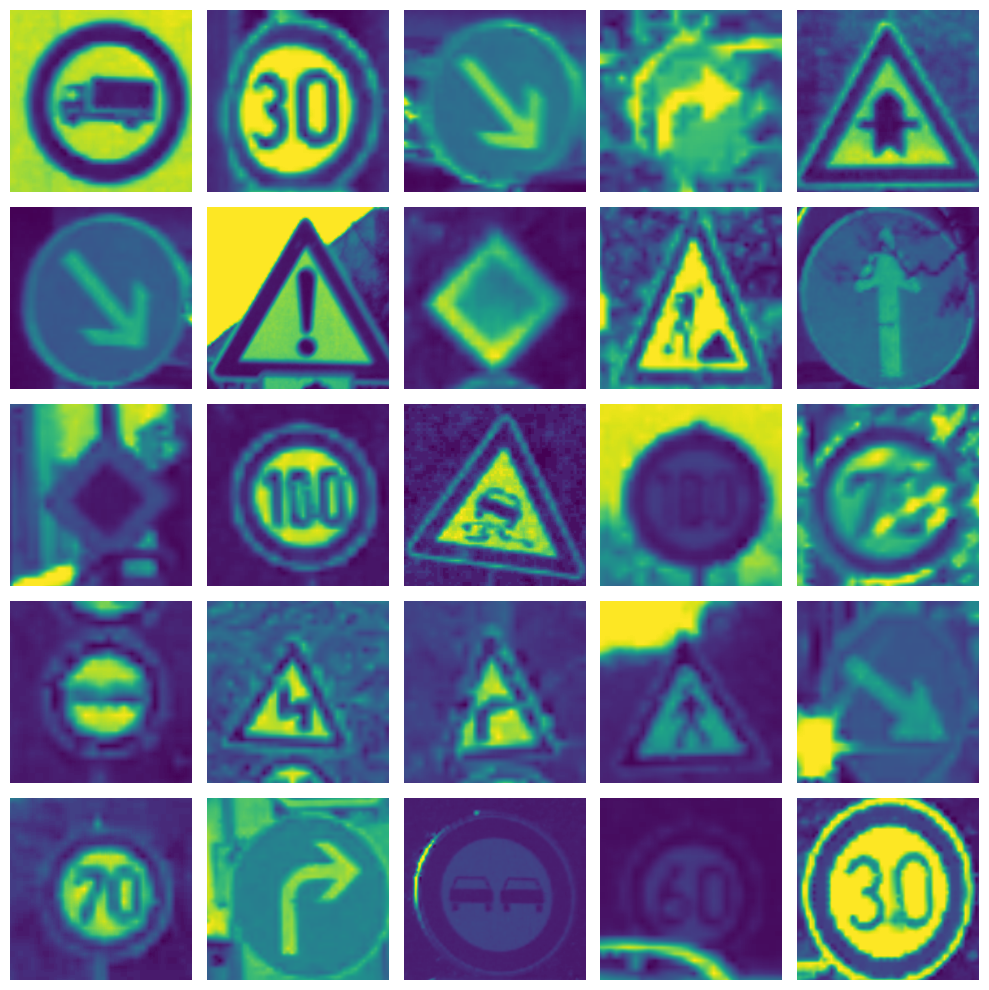

In [668]:
import matplotlib.pyplot as plt

# Create a grid of 5x5 subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot each of the 25 images
for i, ax in enumerate(axes):
    ax.imshow(X[i][2])
    ax.axis('off')  # Hide the axes

# Display the plot
plt.tight_layout()
plt.show()

In [658]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [659]:
import torch.nn.functional as F

# Define model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)

        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(186624, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

        self.lin2 = nn.Linear(128, 43)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.lin1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.lin2(x)
        x = F.log_softmax(x, dim=1)
        return x
    

model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=186624, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (lin2): Linear(in_features=128, out_features=43, bias=True)
)


In [674]:
class_num = 43

class AlexNet(nn.Module):
    def __init__(self, num_classes=43):  # Updated num_classes to 43
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # Adjusted padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # Padding to preserve spatial dimensions
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # Smaller kernel sizes for deeper layers
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # Adjusted based on 224x224 input
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, class_num),  # Updated final layer to match num_classes=43
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)  # Flatten the tensor
        x = self.classifier(x)
        return x


Alex_model = AlexNet().to(device)
print(Alex_model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [804]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Alex_model.parameters(),lr=1e-5)

In [676]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch%100 ==  0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



In [677]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [827]:
def updated_test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    misclassified = []  # To store indices and predictions of misclassified images

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Identify and store misclassified examples
            for i in range(len(y)):
                if pred.argmax(1)[i] != y[i]:
                    misclassified_index = batch_idx * dataloader.batch_size + i
                    misclassified.append({
                        "index": misclassified_index,
                        "predicted": pred.argmax(1)[i].item(),
                        "actual": y[i].item()
                    })

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return misclassified


In [663]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.912387  [   64/26640]
loss: 2.132718  [ 6464/26640]
loss: 1.835786  [12864/26640]
loss: 1.713710  [19264/26640]
loss: 1.500834  [25664/26640]
Test Error: 
 Accuracy: 60.5%, Avg loss: 2.260568 

Epoch 2
-------------------------------
loss: 1.649134  [   64/26640]
loss: 1.367956  [ 6464/26640]
loss: 1.370621  [12864/26640]
loss: 1.405046  [19264/26640]
loss: 1.298066  [25664/26640]
Test Error: 
 Accuracy: 70.3%, Avg loss: 1.961475 

Epoch 3
-------------------------------
loss: 1.295366  [   64/26640]
loss: 1.074211  [ 6464/26640]
loss: 1.219244  [12864/26640]
loss: 1.089100  [19264/26640]
loss: 1.032760  [25664/26640]
Test Error: 
 Accuracy: 73.2%, Avg loss: 1.813271 

Epoch 4
-------------------------------
loss: 0.990752  [   64/26640]
loss: 0.968093  [ 6464/26640]
loss: 0.920476  [12864/26640]
loss: 0.902336  [19264/26640]
loss: 0.782724  [25664/26640]
Test Error: 
 Accuracy: 77.4%, Avg loss: 1.637771 

Epoch 5
------------------------

In [665]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.666484  [   64/26640]
loss: 0.545096  [ 6464/26640]
loss: 0.508259  [12864/26640]
loss: 0.584053  [19264/26640]
loss: 0.487319  [25664/26640]
Epoch 2
-------------------------------
loss: 0.545734  [   64/26640]
loss: 0.521157  [ 6464/26640]
loss: 0.445577  [12864/26640]
loss: 0.460288  [19264/26640]
loss: 0.420114  [25664/26640]
Epoch 3
-------------------------------
loss: 0.397588  [   64/26640]
loss: 0.459868  [ 6464/26640]
loss: 0.420820  [12864/26640]
loss: 0.389180  [19264/26640]
loss: 0.388892  [25664/26640]
Epoch 4
-------------------------------
loss: 0.418498  [   64/26640]
loss: 0.353929  [ 6464/26640]
loss: 0.394642  [12864/26640]
loss: 0.278163  [19264/26640]
loss: 0.290519  [25664/26640]
Epoch 5
-------------------------------
loss: 0.367965  [   64/26640]
loss: 0.305440  [ 6464/26640]
loss: 0.290407  [12864/26640]
loss: 0.239208  [19264/26640]
loss: 0.283195  [25664/26640]
Epoch 6
-------------------------------
loss: 0.27

With batch normalization and a learning rate of 1e-3 and batch size of 64 for the first 50 epochs and a learning rate of 1e-4 and batch size of 32 for the next 5, the test accuracy was ~85% with an avergae loss of ~0.65.

Then retrained on fresh model:
LR: 1e-3, Batch Size: 64, Epochs: 25:
    Accuracy: 82.7%
    Avg Loss: 0.809319

In [685]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, Alex_model, loss_fn, optimizer)
    test(test_dataloader, Alex_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.760528  [   64/26640]
loss: 3.661894  [ 6464/26640]
loss: 3.751395  [12864/26640]
loss: 3.436434  [19264/26640]
loss: 2.493368  [25664/26640]
Test Error: 
 Accuracy: 12.9%, Avg loss: 2.909165 

Epoch 2
-------------------------------
loss: 3.339211  [   64/26640]
loss: 1.989072  [ 6464/26640]
loss: 1.039532  [12864/26640]
loss: 0.942071  [19264/26640]
loss: 0.330248  [25664/26640]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.763221 

Epoch 3
-------------------------------
loss: 0.230275  [   64/26640]
loss: 0.320481  [ 6464/26640]
loss: 0.086303  [12864/26640]
loss: 0.208681  [19264/26640]
loss: 0.187888  [25664/26640]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.423697 

Epoch 4
-------------------------------
loss: 0.220881  [   64/26640]
loss: 0.201972  [ 6464/26640]
loss: 0.161710  [12864/26640]
loss: 0.105620  [19264/26640]
loss: 0.075239  [25664/26640]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.529390 

Epoch 5
------------------------

Using AlexNet and Adam optimizer:

Batch Size: 64, LR: 1e-3, 5 epochs:
    Accuracy: 89.9%
    Average Loss: 0.397131

In [805]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, Alex_model, loss_fn, optimizer)
test(test_dataloader, Alex_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.104553  [   64/26640]
loss: 0.000001  [ 6464/26640]
loss: 0.001323  [12864/26640]
loss: 0.000003  [19264/26640]
loss: 0.009452  [25664/26640]
Epoch 2
-------------------------------
loss: 0.001596  [   64/26640]
loss: 0.000000  [ 6464/26640]
loss: 0.003518  [12864/26640]
loss: 0.001596  [19264/26640]
loss: 0.005692  [25664/26640]
Epoch 3
-------------------------------
loss: 0.002361  [   64/26640]
loss: 0.000039  [ 6464/26640]
loss: 0.027657  [12864/26640]
loss: 0.000000  [19264/26640]
loss: 0.000000  [25664/26640]
Epoch 4
-------------------------------
loss: 0.000000  [   64/26640]
loss: 0.001363  [ 6464/26640]
loss: 0.000218  [12864/26640]
loss: 0.000001  [19264/26640]
loss: 0.000207  [25664/26640]
Epoch 5
-------------------------------
loss: 0.000059  [   64/26640]
loss: 0.000313  [ 6464/26640]
loss: 0.000000  [12864/26640]
loss: 0.000077  [19264/26640]
loss: 0.000394  [25664/26640]
Test Error: 
 Accuracy: 94.9%, Avg loss: 0.647835 

Using AlexNet and Adam optimizer:

Batch Size: 64, LR: 1e-3, 25 epochs:
    Accuracy: 94.0%
    Average Loss: 0.380061

Batch Size: 64, LR: 1e-3 for 100 epochs, then 1e-4 for 10 epochs, and 1e-5 for 5 epochs:
    Accuracy: 94.9%
    Avg loss: 0.647835 

Model Correctly Predicted Sign

Predicted: Stop
Actual: Stop


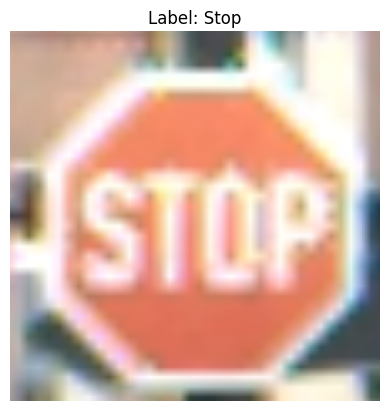

In [826]:
#Evaluate and visualize with test cases:
# List of GTSRB labels and their corresponding descriptions
classes = [
    "Speed limit (20 km/h)",                # 0
    "Speed limit (30 km/h)",                # 1
    "Speed limit (50 km/h)",                # 2
    "Speed limit (60 km/h)",                # 3
    "Speed limit (70 km/h)",                # 4
    "Speed limit (80 km/h)",                # 5
    "End of speed limit (80 km/h)",         # 6
    "Speed limit (100 km/h)",               # 7
    "Speed limit (120 km/h)",               # 8
    "No passing",                           # 9
    "No passing for vehicles over 3.5 metric tons",  # 10
    "Right-of-way at the next intersection",         # 11
    "Priority road",                        # 12
    "Yield",                                # 13
    "Stop",                                 # 14
    "No vehicles",                          # 15
    "Vehicles over 3.5 metric tons prohibited",      # 16
    "No entry",                             # 17
    "General caution",                      # 18
    "Dangerous curve to the left",          # 19
    "Dangerous curve to the right",         # 20
    "Double curve",                         # 21
    "Bumpy road",                           # 22
    "Slippery road",                        # 23
    "Road narrows on the right",            # 24
    "Road work",                            # 25
    "Traffic signals",                      # 26
    "Pedestrians",                          # 27
    "Children crossing",                    # 28
    "Bicycles crossing",                    # 29
    "Beware of ice/snow",                   # 30
    "Wild animals crossing",                # 31
    "End of all speed and passing limits",  # 32
    "Turn right ahead",                     # 33
    "Turn left ahead",                      # 34
    "Ahead only",                           # 35
    "Go straight or right",                 # 36
    "Go straight or left",                  # 37
    "Keep right",                           # 38
    "Keep left",                            # 39
    "Roundabout mandatory",                 # 40
    "End of no passing",                    # 41
    "End of no passing by vehicles over 3.5 metric tons"  # 42
]


listnum = [i for i in range(43)]

Alex_model.eval()
data_num = 4343 #Change this to test with specific cases.
x, z = test_data[data_num][0], test_data[data_num][1]
num = image_test_data[data_num][0] #To show the image without the normalization
num = num.cpu().numpy().transpose(1,2,0) #So that it can fit into the show image function

x = x.unsqueeze(0).to(device) 
with torch.no_grad():
    pred = Alex_model(x)
    val = pred.argmax(dim=1).item()
    predicted = classes[val]  #Store what the model predicted
    actual = classes[z]  # Get the actual class label
    
if val == z:
    print("Model Correctly Predicted Sign\n")
else:
    print("Model Incorrectly Predicted Sign\n")
# Output the result
print(f'Predicted: {predicted}\nActual: {actual}')

# Visualize the image with its predicted label
show_image(num, actual)

In [806]:
test(test_dataloader, Alex_model, loss_fn)

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.647835 



In [846]:
test(test_dataloader, Alex_model, loss_fn)

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.647835 



In [843]:
def show_misclassified_images(misclassified, dataset, num_images_to_show):
    """
    Displays the images, predicted labels, and actual labels for misclassified examples.
    
    Parameters:
        misclassified (list): List of dictionaries containing 'index', 'predicted', and 'actual' keys.
        dataset (torch.utils.data.Dataset): The dataset from which the images are drawn.
        num_images_to_show (int): Number of misclassified images to display (default is 10).
    """
    # Ensure we don't try to show more images than we have
    num_images_to_show = min(num_images_to_show, len(misclassified))
    
    plt.figure(figsize=(60, 60))
    
    for i in range(num_images_to_show):
        # Get the misclassified example details
        index = misclassified[i]['index']
        predicted_label = misclassified[i]['predicted']
        actual_label = misclassified[i]['actual']
        
        # Get the corresponding image and label from the dataset
        image, _ = dataset[index]
        
        # Display the image with its predicted and actual labels
        plt.subplot(num_images_to_show, 1, i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert [C, H, W] to [H, W, C] for display
        plt.title(f"Pred: {classes[predicted_label]}\nActual: {classes[actual_label]}")
        plt.axis('off')

    
    plt.tight_layout()
    plt.show()



In [845]:
#show_misclassified_images(updated_test(test_dataloader, Alex_model, loss_fn), image_test_data, 25)